In [125]:
from zipfile import ZipFile
import csv
import cv2
import pickle
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage import util, exposure
from sklearn.utils import shuffle
from tensorflow.keras import models, layers

In [3]:
!wget https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip -O data.zip

with ZipFile('data.zip', 'r') as zipObj:
   zipObj.extractall()
   print('Finish extracting')

--2020-10-04 07:34:35--  https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip
Resolving d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)... 13.225.84.45, 13.225.84.31, 13.225.84.56, ...
Connecting to d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)|13.225.84.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 333137665 (318M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================&gt;] 317,70M  9,28MB/s    in 33s     

2020-10-04 07:35:08 (9,65 MB/s) - ‘data.zip’ saved [333137665/333137665]

Finish extracting


Size:		 8036
Columns:	 [&#39;center&#39;, &#39;left&#39;, &#39;right&#39;, &#39;steering&#39;]



&lt;AxesSubplot:ylabel=&#39;Frequency&#39;&gt;

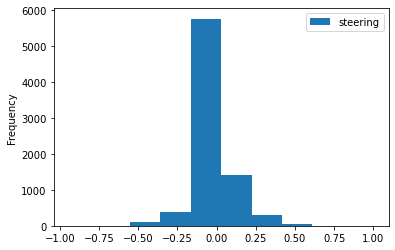

In [126]:
log_data = pd.read_csv('./data/driving_log.csv')  
log_data.drop(columns=['throttle','brake','speed'],inplace=True)
print('Size:\t\t',len(log_data))
print('Columns:\t',list(log_data.columns),)
print()
log_data.plot.hist()

In [127]:
def get_side_cameras(log_line,correction = 0.25):
    steering_left = log_line.steering + correction
    path_left = './data/'+log_line.left.strip()
    image_left = cv2.imread(path_left)
    image_left = cv2.cvtColor(image_left,cv2.COLOR_BGR2RGB)

    steering_right = log_line.steering - correction
    path_right = './data/'+log_line.right.strip()
    image_right = cv2.imread(path_right)
    image_right = cv2.cvtColor(image_right,cv2.COLOR_BGR2RGB)
    return image_left,steering_left,image_right,steering_right


def batch_loader(log_select,training=True):
    images = []
    measurements = []
    for l in log_select.itertuples():
        path = './data/'+l.center
        image = cv2.imread(path)
        # Fix for udacity simulator
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        if np.random.rand() > .5:
            image = util.random_noise(image)
        if np.random.rand() > .5:
            image = exposure.adjust_gamma(image, np.random.uniform(0.75,1.25))
        images.append(image)
        measure = l.steering
        measurements.append(measure)
        #Include side cameras
        #if training:
        img_left,measure_left,img_right,measure_right = get_side_cameras(l)
        images.append(img_left)
        measurements.append(measure_left)
        images.append(img_right)
        measurements.append(measure_right)
    return np.asarray(images),np.asarray(measurements)

def train_test_val(log_data_frame, train_ratio, test_ratio, val_ratio):
    assert sum([train_ratio, test_ratio, val_ratio])==1.0
    log_data_frame = shuffle(log_data_frame)
    data_size = len(log_data_frame)
    id_train = int(round(data_size*train_ratio))
    id_test = int(round(data_size*(train_ratio+test_ratio)))

    train = log_data_frame[:id_train]
    test = log_data_frame[id_train:id_test]
    validation = log_data_frame[id_test:]
    #print(len(log_data_frame),len(train)+len(test)+len(validation))
    return train, test, validation

def flip(in_images,in_labels):
    result_images =[]
    result_measures =[]
    for i,img in enumerate(in_images):
        result_images.append(np.fliplr(img))
        flip_measure = 0.0
        if in_labels[i] != 0.0:
            flip_measure = - in_labels[i]
        result_measures.append(flip_measure)
    
    result_images = np.asarray(result_images)
    result_measures = np.asarray(result_measures)
    assert len(in_images)==len(result_images)
    return result_images,result_measures

def convert_gray(images):
    return np.sum(images/3,axis=3,keepdims=True)


In [128]:
train_log, test_log, validation_log = train_test_val(log_data,0.6,0.2,0.2)
print(len(log_data),len(train_log),len(test_log),len(validation_log))
visualization_images,visualization_labels = batch_loader(train_log[:10])
print(visualization_images.shape,visualization_labels.shape)


8036 4822 1607 1607
(30, 160, 320, 3) (30,)


0.0 0.0
(30, 160, 320, 1) (30, 160, 320, 1) (30,)


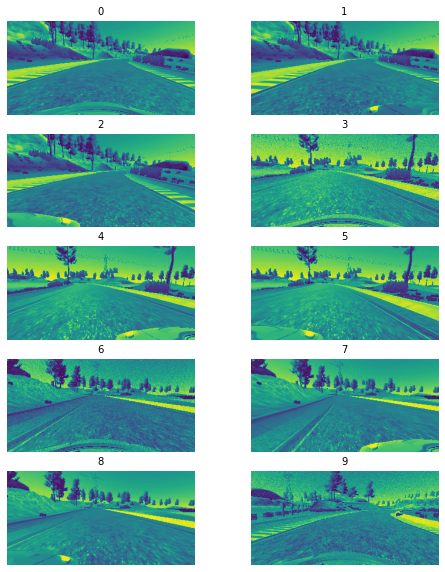

In [129]:
gray_images = convert_gray(visualization_images)
flip_images,flip_labels = flip(gray_images,visualization_labels)
print(visualization_labels[0],flip_labels[0])
print(gray_images.shape,flip_images.shape,flip_labels.shape)
fig, axes = plt.subplots(5,2, figsize=(8,10))

for i,ax in  enumerate(axes.flat):
    ax.set_title(i,fontsize=10)
    ax.imshow(gray_images[i])
    ax.set_axis_off()

In [130]:
def image_generator(logs, batch_size, training=True):
    while True:
        start = 0
        end = batch_size
        while start  < len(logs):
            selected = logs[start:end]
            images,labels = batch_loader(selected,training)
            if training:
                flip_img,flip_labels = flip(images,labels)
                images = np.vstack((flip_img,images))
                labels = np.hstack((flip_labels,labels))
            yield images,labels
            start += batch_size
            end += batch_size


In [131]:
generator = image_generator(validation_log[0:10],10,training=True)
gen_images,gen_labels=next(generator)
#print(gen_images.shape,gen_labels.shape)
img_shape = gen_images[0].shape
batch_size = 32
steps_per_epoch = math.ceil(len(train_log)/batch_size)
validation_steps_per_epoch = math.ceil(len(validation_log)/batch_size)
test_steps_per_epoch = math.ceil(len(test_log)/batch_size)
#print(img_shape)

In [132]:
def simple_net(input_shape,learning_rate):
    model = models.Sequential()
    model.add(layers.Lambda(lambda x: x/127.5-1.,input_shape=input_shape))
    model.add(layers.Cropping2D(cropping=((50,20), (0,0)) ))    
    model.add(layers.Convolution2D(24,5,5,activation='relu'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(120))
    model.add(layers.Dense(1))
    return model

def LeNet5(input_shape,dropout,learning_rate):
    model = models.Sequential()
    model.add(layers.Lambda(lambda x: x/127.5 - 1., input_shape=input_shape))
    model.add(layers.Convolution2D(64,5,5,activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Convolution2D(36,5,5,activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(120))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(84))
    model.add(layers.Dense(1))
    return model

def Nvidia(input_shape,dropout):
    model = models.Sequential()
    model.add(layers.Lambda(lambda x: x/255.0-0.5,input_shape=input_shape))
    model.add(layers.Cropping2D(cropping=((70,25), (0,0))))
    model.add(layers.Convolution2D(24,5,2,activation='relu'))
    model.add(layers.Convolution2D(36,5,2,activation='relu'))
    model.add(layers.Convolution2D(48,5,2,activation='relu'))
    model.add(layers.Dropout(dropout))
    model.add(layers.Convolution2D(64,3,activation='relu'))
    model.add(layers.Convolution2D(64,3,activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(100))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(50))
    model.add(layers.Dense(10))
    model.add(layers.Dense(1))
    return model


Epoch 1/15
151/151 [==============================] - 107s 709ms/step - loss: 0.0282 - accuracy: 0.1813 - val_loss: 0.0216 - val_accuracy: 0.1803
Epoch 2/15
151/151 [==============================] - 108s 713ms/step - loss: 0.0231 - accuracy: 0.1813 - val_loss: 0.0199 - val_accuracy: 0.1803
Epoch 3/15
151/151 [==============================] - 108s 714ms/step - loss: 0.0212 - accuracy: 0.1813 - val_loss: 0.0190 - val_accuracy: 0.1803
Epoch 4/15
151/151 [==============================] - 106s 705ms/step - loss: 0.0204 - accuracy: 0.1813 - val_loss: 0.0186 - val_accuracy: 0.1803
Epoch 5/15
151/151 [==============================] - 106s 699ms/step - loss: 0.0199 - accuracy: 0.1813 - val_loss: 0.0184 - val_accuracy: 0.1803
Epoch 6/15
151/151 [==============================] - 107s 708ms/step - loss: 0.0190 - accuracy: 0.1813 - val_loss: 0.0182 - val_accuracy: 0.1803
Epoch 7/15
151/151 [==============================] - 108s 712ms/step - loss: 0.0186 - accuracy: 0.1813 - val_loss: 0.0182 -

[&lt;matplotlib.lines.Line2D at 0x7f1bc44357f0&gt;]

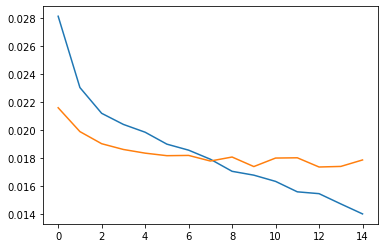

In [133]:
#model = simple_net(img_shape,0.001)
#model = LeNet5(img_shape,0.25,0.0003)
learning_rate = 0.0003
epochs = 15
model = Nvidia(img_shape,0.25)
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate),metrics=['accuracy'])
history = model.fit(image_generator(train_log,batch_size),
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=image_generator(validation_log,128,training=False),
                    validation_steps=validation_steps_per_epoch,
                    shuffle=True,
                    verbose=1)

# Plot the loss and the accuracy                    

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [134]:
model.save('model.h5')


In [135]:
scores = model.evaluate(image_generator(test_log,128,training=False),
                        verbose=1,
                        epochs=5,
                        steps=test_steps_per_epoch)
print(scores)

TypeError: evaluate() got an unexpected keyword argument &#39;epochs&#39;